In [ ]:
!pip install torchmetrics

In [ ]:
! pip install lpips

In [ ]:
import sys
import os
import torch
import numpy as np
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1slbiyvE5gYnaYMkgD42Iwx1u_NhpAv_A' -O loss_selection.zip

--2025-02-16 09:02:48--  https://docs.google.com/uc?export=download&id=1slbiyvE5gYnaYMkgD42Iwx1u_NhpAv_A
Resolving docs.google.com (docs.google.com)... 142.251.170.139, 142.251.170.102, 142.251.170.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.170.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1slbiyvE5gYnaYMkgD42Iwx1u_NhpAv_A&export=download [following]
--2025-02-16 09:02:49--  https://drive.usercontent.google.com/download?id=1slbiyvE5gYnaYMkgD42Iwx1u_NhpAv_A&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.125.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813204 (2.7M) [application/octet-stream]
Saving to: ‘loss_selection.zip’

loss_selection.zip  100%[===================>]   2.68M  --.

In [ ]:
!unzip loss_selection.zip
!rm -r /content/__MACOSX

In [ ]:
class BinarizeTransform:
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def __call__(self, tensor):
        # Assuming the input tensor is of shape (1, 1, 1024, 1024)
        # Convert the tensor to a NumPy array
        image_array = tensor.squeeze().numpy()  # Shape will be (1024, 1024)

        # Binarize the image
        binarized_image = (image_array > self.threshold).astype(np.float32)  # Binary (0 or 1)

        # Convert back to tensor and maintain shape (1, 1, 1024, 1024)
        return torch.from_numpy(binarized_image).unsqueeze(0)  # Shape will be (1, 1, 1024, 1024)

class EvalDataset(Dataset):
    def __init__(self, target_dir, mask_dir, transform=None):
        self.target_dir = target_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(target_dir)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        target_path = os.path.join(self.target_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        target = Image.open(target_path)
        mask = Image.open(mask_path)

        if self.transform:
            target = self.transform(target)
            mask = self.transform(mask)
        return target, mask

In [ ]:
TARGET_PATH = '/content/loss_selection/gt'
MASK_PATH = '/content/loss_selection/pred'
BATCH_SIZE = 1

TRANSFORM = transforms.Compose([transforms.Resize((1024,1024)),
                                transforms.ToTensor(),
                                transforms.Grayscale(),
                                BinarizeTransform(threshold=0.5)])

EVAL_DATASET = EvalDataset(TARGET_PATH, MASK_PATH, transform = TRANSFORM)
EVAL_LOADER = DataLoader(EVAL_DATASET, batch_size = BATCH_SIZE, shuffle=True)

(-0.5, 1023.5, 1023.5, -0.5)

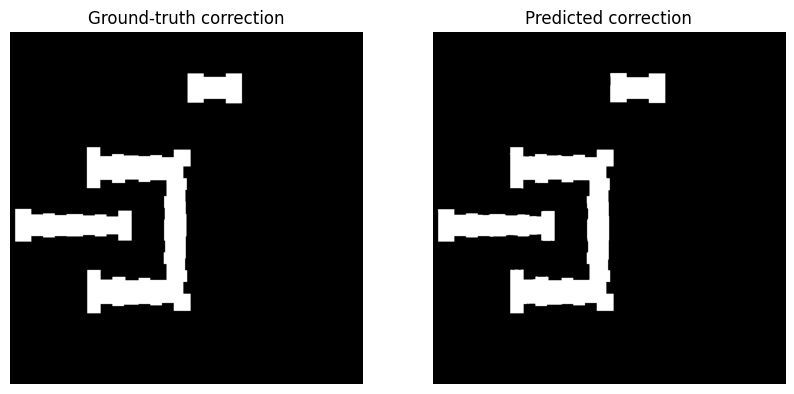

In [ ]:
gt, pred = next(iter(EVAL_LOADER))

fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(gt.squeeze(), cmap='gray')
axes[0].set_title('Ground-truth correction')
axes[0].axis('off')

axes[1].imshow(pred.squeeze(), cmap='gray')
axes[1].set_title('Predicted correction')
axes[1].axis('off')


## Visualize difference

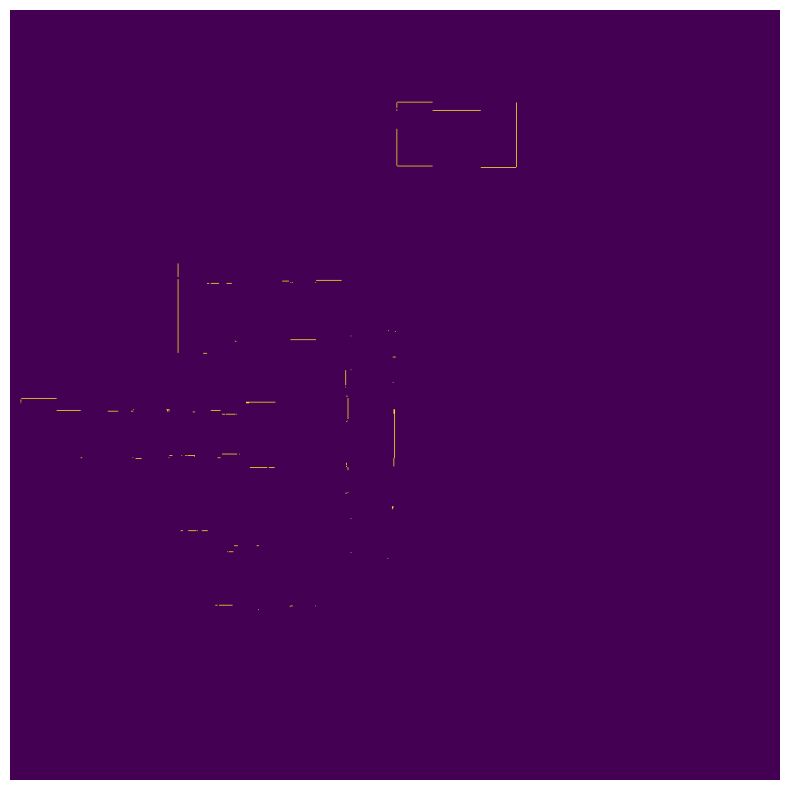

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(torch.abs(pred - gt).squeeze().numpy(), vmin=0, vmax=1)
plt.axis('off')
plt.show()

## IoU loss

In [ ]:
class IouLoss(nn.Module):
  def __init__(self, weight=1.0, eps=1e-6):
    super(IouLoss, self).__init__()
    self.weight = weight
    self.eps = eps
  def forward(self, pred, target):
    intersection = (pred * target).sum(dim=(2, 3))
    union = (pred + target).sum(dim=(2, 3)) - intersection
    iou = (intersection + self.eps) / (union + self.eps)
    return (1 - iou.mean()) * self.weight

iou_loss = IouLoss()
print(f'IoU loss value:{iou_loss(gt, pred)}')

IoU loss value:0.010557770729064941


## MAE Loss

In [ ]:
l1_loss = torch.nn.L1Loss()
print(f'L1_loss value: {l1_loss(gt, pred)}')

L1_loss value: 0.0010251998901367188


In [ ]:
from torchmetrics.image import TotalVariation

l1_loss_sum = torch.nn.L1Loss(reduction='sum')
l1_loss_mean = torch.nn.L1Loss()

l1_score_sum = l1_loss_sum(gt, pred)
print(f'L1 sum:{l1_score_sum}')

l1_score_mean = l1_loss_mean(gt, pred)
print(f'L1 mean:{l1_score_mean}')

print(f'Custom calculation #1: {((torch.abs(gt - pred)).sum() / (1024 * 1024))}')
print(f'Summ: {torch.abs(gt - pred).sum()}')

# normalize by union
print(f'Custom calculation #2: {((torch.abs(gt - pred)).sum() / ((torch.abs(gt + pred)).sum()))}')
# normalize by intersection
print(f'Custom calculation #3: {((torch.abs(gt - pred)).sum() / ((torch.abs(gt * pred)).sum()))}')
# normalize by gt area
print(f'Custom calculation #4: {(torch.abs(gt - pred)).sum() / ((gt.sum()))}')

tv = TotalVariation()
print(f'Total Variation for gt: {tv(gt)}')
print(f'Total Variation for pred: {tv(pred)}')
print(f'Relative: {torch.abs((tv(gt) - tv(pred))) / tv(gt) }')

## Structural similarity index (SSIM) loss

**What It Measures:** SSIM evaluates the perceived quality of an image by comparing luminance, contrast, and structure between the generated and ground-truth images.
**Why Use It:** SSIM is better at capturing perceptual differences than pixel-wise metrics like IoU or Pixel Accuracy. It is particularly useful for evaluating the structural similarity of images.

In [ ]:
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM

ssim = SSIM(data_range=1.0)  # Assuming pixel values are in [0, 1]
ssim_score = ssim(pred, gt)
print(f'SSIM_loss value: {ssim_score}')

SSIM_loss value: 0.9926246404647827


## Edge Loss

**What It Measures:** These metrics evaluate how well the edges in the generated image match those in the ground-truth image.

**Why Use It:** For OPC tasks, preserving sharp edges is critical. Edge preservation metrics can help assess the quality of edge reconstruction

**Implementation**:


*   Use Sobel or Canny edge detector to extract edges from both generated and ground-truth images
*   Compute L1-difference between derived edges
*   Two implementations are provided: raw difference between edges and difference normalized by the area of the target itself



In [ ]:
import torch.nn.functional as F

def sobel_edge_detector(image):
    kernel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(image.device)
    kernel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(image.device)
    grad_x = F.conv2d(image, kernel_x, padding=1)
    grad_y = F.conv2d(image, kernel_y, padding=1)
    return torch.sqrt(grad_x ** 2 + grad_y ** 2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
edges_pred = sobel_edge_detector(pred)
edges_target = sobel_edge_detector(gt)
edge_loss_1 = F.l1_loss(edges_pred, edges_target)

edge_loss_2 = F.l1_loss(edges_pred, edges_target, reduction='sum')
print(f'Edge_loss #1: {edge_loss_1}')
print(f'Edge_loss #2: {edge_loss_2}')

Edge_loss #1: 0.008262952789664268
Edge_loss #2: 8664.333984375


In [ ]:
class ContourLoss(nn.Module):
  def __init__(self, weight=1.0, device='cpu'):
    super(ContourLoss, self).__init__()
    self.weight = weight
    self.device = device
    self.sobel_kernel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1,0,-1]], dtype = torch.float32, device = device).view(1,1,3,3)
    self.sobel_kernel_y = torch.tensor([[1,2,1], [0,0,0], [-1, -2, -1]], dtype = torch.float32, device = device).view(1,1,3,3)
  def forward(self, pred, target):
    target_edge_x = torch.nn.functional.conv2d(target, self.sobel_kernel_x, padding = 1)
    target_edge_y = torch.nn.functional.conv2d(target, self.sobel_kernel_y, padding = 1)
    target_edge = torch.sqrt(target_edge_x ** 2 + target_edge_y ** 2 + 1e-6)
    pred_edge_x = torch.nn.functional.conv2d(pred, self.sobel_kernel_x, padding = 1)
    pred_edge_y = torch.nn.functional.conv2d(pred, self.sobel_kernel_y, padding = 1)
    pred_edge = torch.sqrt(pred_edge_x ** 2 + pred_edge_y ** 2 + 1e-6)
    # calculate difference for every predicted and target correction in a batch
    loss_per_image = torch.abs(pred_edge - target_edge).sum(dim=(1,2,3)) # (N, ), sum over height, width and channels
    # calculate the contour area for every target correction in a batch
    target_edge_sum = target_edge.sum(dim=(1,2,3)) + 1e-6 # (N, ) sum over height, width, and prevent division by zero
    # normalise the difference by the contour area of target correction
    mean_loss = (loss_per_image / target_edge_sum) * self.weight
    # return mean value over a batch
    return mean_loss.mean()
contour_loss = ContourLoss()
print(f'Contour Loss value: {contour_loss(pred, gt)}')

Contour Loss value: 0.2712148129940033


## Perceptual Loss

**What It Measures:** LPIPS (Learned Perceptual Image Patch Similarity) uses a pre-trained neural network (e.g., VGG) to compare the perceptual similarity between images

**Why Use It:** LPIPS captures high-level features and is more aligned with human perception than pixel-wise metrics

In [ ]:
import lpips

lpips_loss_vgg = lpips.LPIPS(net='vgg')  # Use 'alex' or 'vgg'
lpips_loss_alex = lpips.LPIPS(net='alex')

lpips_score_vgg = lpips_loss_vgg(pred, gt)
lpips_score_alex = lpips_loss_alex(pred, gt)

print(f'Perceptual Loss value (VGG): {lpips_score_vgg}')
print(f'Perceptual Loss value (AlexNet): {lpips_score_alex}')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Perceptual Loss value (VGG): tensor([[[[0.0153]]]], grad_fn=<AddBackward0>)
Perceptual Loss value (AlexNet): tensor([[[[0.0135]]]], grad_fn=<AddBackward0>)


## Frechet Inception distance

**What It Measures:** FID evaluates the quality of generated images by comparing the distribution of features extracted from a pre-trained Inception network.

**Why Use It:** FID is widely used in generative models to assess the realism and diversity of generated images

*thrown an error, seems to be working with RGB images*

In [ ]:
!pip install torch-fidelity

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(feature=2048)  # Use feature=768 for Inception v3
fid.update(torch.tensor(pred, dtype=torch.uint8), real=False)
fid.update(torch.tensor(gt, dtype=torch.uint8), real=True)
fid_score = fid.compute()
print(f'Frechet loss value:{fid_score}')

## Dice coefficient

**What It Measures:** The Dice coefficient is similar to IoU but is more sensitive to overlapping regions.

**Why Use It:** It is commonly used in medical imaging and segmentation tasks to evaluate overlap between predicted and ground-truth masks

In [ ]:
def dice_coefficient(pred, target, eps=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2 * intersection + eps) / (union + eps)

dice_score = dice_coefficient(pred, gt)
print(f'Dice score: {dice_score}')
print(f'Dice loss: {1 - dice_score}')

Dice score: 0.9946931004524231
Dice loss: 0.005306899547576904


## Fourier loss

Seems to be the best solution!!!

> Since your enhancer network is struggling with small pixel-level distortions and edge artifacts, a frequency-domain approach might help by removing high-frequency noise and preserving the structure. Here’s how you can integrate Fourier Transform-based loss functions into your training.

🔹 Why Use Frequency Domain Processing?

1️⃣ Edge distortions often appear as high-frequency components → Can be suppressed in the frequency domain

2️⃣ Important structural features (shapes, contours) have low-frequency components → Should be preserved

3️⃣ Pixel-wise losses (L1, L2) focus on spatial similarity, but frequency loss captures structural consistency



🔹 How to Convert an Image to the Frequency Domain?

The Fourier Transform (FFT) decomposes an image into frequency components:

	•	Low frequencies → Large-scale structures (overall shape)
	•	High frequencies → Fine details (sharp edges, noise, artifacts)


In [ ]:
def to_frequency_domain(image):
  '''
  obtain the magnitude spectrum which tells us the strength of different
  frequency components
  '''
  fft = torch.fft.fft2(image) # Compute 2d Fourier transform
  fft_shift = torch.fft.fftshift(fft) # Shift zero frequency to center
  magnitude = torch.abs(fft_shift) # Get magnitude spectrum

  return magnitude

def fourier_loss(pred, target):
  pred_freq = to_frequency_domain(pred)
  target_freq = to_frequency_domain(target)

  return F.l1_loss(pred_freq, target_freq)

print(f'Fourier loss: {fourier_loss(pred, gt)}')

Fourier loss: 10.269524574279785


In [ ]:
def high_pass_filter(freq_image, threshold=20):
  """
  Zero out  low-frequency components below the threshold
  """
  _, _, h, w = freq_image.shape
  center_h ,center_w = h // 2, w // 2
  mask = torch.ones_like(freq_image)
  mask[:, :, center_h-threshold:center_h+threshold, center_w-threshold:center_w+threshold] = 0
  return freq_image * mask

def high_frequency_loss(pred, target):
  pred_freq = to_frequency_domain(pred)
  target_freq = to_frequency_domain(target)

  pred_high = high_pass_filter(pred_freq)
  target_high = high_pass_filter(target_freq)

  return F.l1_loss(pred_high, target_high)
print(f'High frequency loss: {high_frequency_loss(pred, gt)}')

High frequency loss: 10.149885177612305
